In [0]:
import pandas as pd
import numpy as np

In [0]:
from google.colab import drive
drive.mount('/data/')

Drive already mounted at /data/; to attempt to forcibly remount, call drive.mount("/data/", force_remount=True).


In [0]:
data = pd.read_excel('/data/My Drive/Colab Notebooks/jds/DataSet.xlsx')

In [0]:
data.head()

,Чек,Магазин,Название товара,Вид оплаты,Карта лояльности,Цена,Сумма Итоговая,Сумма скидки,Количество,Сумма скидки без округления,Сумма округления
0,Чек 61484 от 01.10.2018 10:05:20,Магазин 1,"PL Молоко цельное 1л мдж 3,5% -5,2%",Visa,23489164220602890,118.00,220.0,16.00,2.0,16.0,NaN
1,Чек 61484 от 01.10.2018 10:05:20,Магазин 1,"PL Ряженка 4,0% 500 гр",Visa,23489164220602890,67.00,62.0,5.00,1.0,5.0,NaN
2,Чек 61484 от 01.10.2018 10:05:20,Магазин 1,PL Сметана 20% 250 гр,Visa,23489164220602890,119.00,112.0,7.00,1.0,7.0,NaN
3,Чек 61484 от 01.10.2018 10:05:20,Магазин 1,PL Творог 9% 200 гр,Visa,23489164220602890,109.00,204.0,14.00,2.0,14.0,NaN
4,Чек 61484 от 01.10.2018 10:05:20,Магазин 1,"Пакеты ""Майка"" с логотипом",Visa,23489164220602890,0.01,NaN,0.02,2.0,NaN,0.02


In [0]:
data.shape

(257930, 11)

In [0]:
data.columns

Index(['Чек', 'Магазин', 'Название товара', 'Вид оплаты', 'Карта лояльности',
       'Цена', 'Сумма Итоговая', 'Сумма скидки', 'Количество',
       'Сумма скидки без округления', 'Сумма округления'],
      dtype='object')

In [0]:
data.isna().sum()

Чек                                 0
Магазин                             0
Название товара                     0
Вид оплаты                       2348
Карта лояльности                46267
Цена                                0
Сумма Итоговая                  23590
Сумма скидки                   118531
Количество                          0
Сумма скидки без округления    167598
Сумма округления               183213
dtype: int64

In [0]:
#data = data.loc[data['Карта лояльности'].dropna().index]

In [0]:
data['customers_id'] = data['Карта лояльности'].fillna(data[data['Карта лояльности'].isna()]['Чек'])

In [0]:
data['Сумма округления'] = data['Сумма округления'].fillna(0)

In [0]:
data['Вид оплаты'] = data['Вид оплаты'].fillna('Наличные')

In [0]:
data['Сумма скидки'] = data['Сумма скидки'].fillna(0)

In [0]:
data['Сумма скидки без округления'] = data['Сумма скидки без округления'].fillna(0)

In [0]:
data['Сумма Итоговая'] = data['Сумма Итоговая'].fillna(0)

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [0]:
data['customers_id'] = le.fit_transform(data['customers_id'])
data = data.set_index('customers_id')

In [0]:
data.head()

,Чек,Магазин,Название товара,Вид оплаты,Карта лояльности,Цена,Сумма Итоговая,Сумма скидки,Количество,Сумма скидки без округления,Сумма округления
customers_id,,,,,,,,,,,
6310,Чек 61484 от 01.10.2018 10:05:20,Магазин 1,"PL Молоко цельное 1л мдж 3,5% -5,2%",Visa,23489164220602890,118.00,220.0,16.00,2.0,16.0,0.00
6310,Чек 61484 от 01.10.2018 10:05:20,Магазин 1,"PL Ряженка 4,0% 500 гр",Visa,23489164220602890,67.00,62.0,5.00,1.0,5.0,0.00
6310,Чек 61484 от 01.10.2018 10:05:20,Магазин 1,PL Сметана 20% 250 гр,Visa,23489164220602890,119.00,112.0,7.00,1.0,7.0,0.00
6310,Чек 61484 от 01.10.2018 10:05:20,Магазин 1,PL Творог 9% 200 гр,Visa,23489164220602890,109.00,204.0,14.00,2.0,14.0,0.00
6310,Чек 61484 от 01.10.2018 10:05:20,Магазин 1,"Пакеты ""Майка"" с логотипом",Visa,23489164220602890,0.01,0.0,0.02,2.0,0.0,0.02


In [0]:
data['shop_id'] = le.fit_transform(data['Магазин'])

In [0]:
data['payment_method'] = le.fit_transform(data['Вид оплаты'])

In [0]:
data['purchase'] = le.fit_transform(data['Чек'])

In [0]:
data['purchase_dt'] = pd.to_datetime(data['Чек'].apply(lambda x: x[x.find('от')+2:]), dayfirst=True)

In [0]:
#data['purchase_count'] = data.reset_index().groupby(['customers_id']).nunique()['purchase']
#data['purchase_sum_mean'] = data.reset_index().groupby('customers_id').sum()['Сумма Итоговая'] / data['purchase_count']

In [0]:
X = pd.DataFrame([])

In [0]:
X['purchase_count'] = data.groupby(['customers_id']).nunique()['purchase']

In [0]:
X['purchase_dt'] =  data.max()['purchase_dt'].dayofyear - pd.to_datetime(data.groupby('customers_id').max()['purchase_dt']).dt.dayofyear

In [0]:
X['purchase_sum_mean'] = data.groupby('customers_id').sum()['Сумма Итоговая'] / X['purchase_count']

In [0]:
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import euclidean

In [0]:
data['td'] = (data.groupby('customers_id').max()['purchase_dt'] - data.groupby('customers_id').min()['purchase_dt']).apply(lambda x: x.days)

In [0]:
X['td'] = data['td'].groupby('customers_id').mean()

In [0]:
X['cltv'] = X['td']*X['purchase_sum_mean']

In [0]:
data['cltv'] = X['cltv']

In [0]:
from scipy.stats import zscore

In [0]:
X = X[zscore(X['purchase_sum_mean'])<5]

In [0]:
X = X[zscore(X['purchase_count'])<5]

In [0]:
X.head()

,purchase_count,purchase_dt,purchase_sum_mean,td,cltv
customers_id,,,,,
0,1,49,2171.0,0,0.0
1,2,4,514.0,3,1542.0
2,1,56,458.0,0,0.0
3,4,51,407.5,22,8965.0
4,5,53,652.2,21,13696.2


In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 100))
X['purchase_dt'] = scaler.fit_transform(X['purchase_dt'].values.reshape(-1, 1))

scaler = MinMaxScaler(feature_range=(0, 100))
X['purchase_sum_mean'] = scaler.fit_transform(X['purchase_sum_mean'].values.reshape(-1, 1))

scaler = MinMaxScaler(feature_range=(0, 100))
X['purchase_count'] = scaler.fit_transform(X['purchase_count'].values.reshape(-1, 1))

In [0]:
def max_dist(df, center, i):
    d = []
    for row in df.values:
        if row[3] == i:
            d.append(euclidean(row[:3], center))
    return max(d) if d else float('Inf')

In [0]:
def all_dist(df, centers):
    d = []
    for i in range(len(centers)):
        max_d = max_dist(df, centers[i], i)
        for j in range(len(centers)):
            if i != j:
                d.append(max_d / euclidean(centers[i], centers[j]))
    return d

In [0]:
d = []
for i in range(3, 15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X[['purchase_count', 'purchase_dt', 'purchase_sum_mean']])
    X['cluster'] = kmeans.predict(X[['purchase_count', 'purchase_dt', 'purchase_sum_mean']])
    c = kmeans.cluster_centers_
    d.append(max(all_dist(X, c)))

In [62]:
d

[3.4536961911972623,
 3.0613952174090127,
 3.5470158163167103,
 4.692367513686709,
 5.45165443267187,
 4.900209099843612,
 6.742209712419742,
 7.794816336028683,
 7.415230122201661,
 6.762150104922072,
 7.596961244262224,
 9.423521245931218]

In [0]:
best_k = np.argmin(d)+3

In [0]:
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(X[['purchase_count', 'purchase_dt', 'purchase_sum_mean']])
X['cluster'] = kmeans.predict(X[['purchase_count', 'purchase_dt', 'purchase_sum_mean']])

In [0]:
Y = pd.DataFrame({'purchase_sum_mean':[0]*best_k,
                  'purchase_count_mean':[0]*best_k,
                  'last_date_mean':[0]*best_k,
                  'cluster': list(range(best_k)), 
                  'count_clients':[0]*best_k, 
                  'mean_cltv':[0]*best_k})

In [0]:
for i in range(best_k):
    Y.loc[Y['cluster'] == i, 'purchase_sum_mean'] = X[X['cluster'] == i]['purchase_sum_mean'].mean()
    Y.loc[Y['cluster'] == i, 'purchase_count_mean'] = X[X['cluster'] == i]['purchase_count'].mean()
    Y.loc[Y['cluster'] == i, 'last_date_mean'] = X[X['cluster'] == i]['purchase_dt'].mean()
    Y.loc[Y['cluster'] == i, 'count_clients'] = len(X[X['cluster'] == i]['purchase_dt'])
    Y.loc[Y['cluster'] == i, 'mean_cltv'] = X[X['cluster'] == i]['cltv'].mean()

In [46]:
Y

,purchase_sum_mean,purchase_count_mean,last_date_mean,cluster,count_clients,mean_cLTV
0,6.301515,0.351943,83.062935,0,7322,772.173909
1,8.774808,2.750477,14.022557,1,9713,17183.084029
2,12.092782,48.894582,6.834042,2,1096,113031.884646
3,7.658589,1.100150,46.939293,3,8796,4765.273017


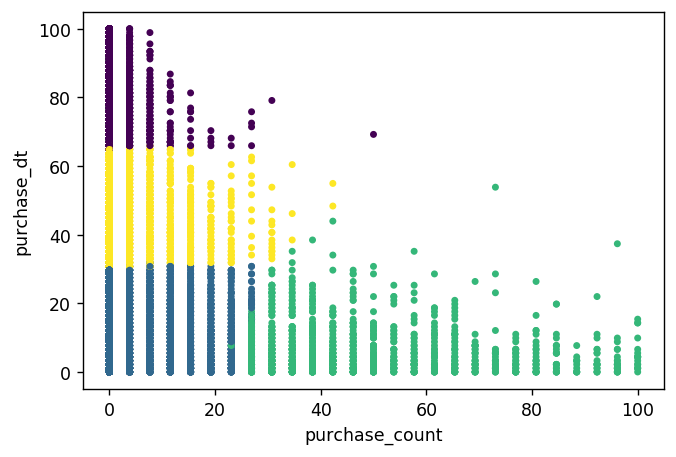

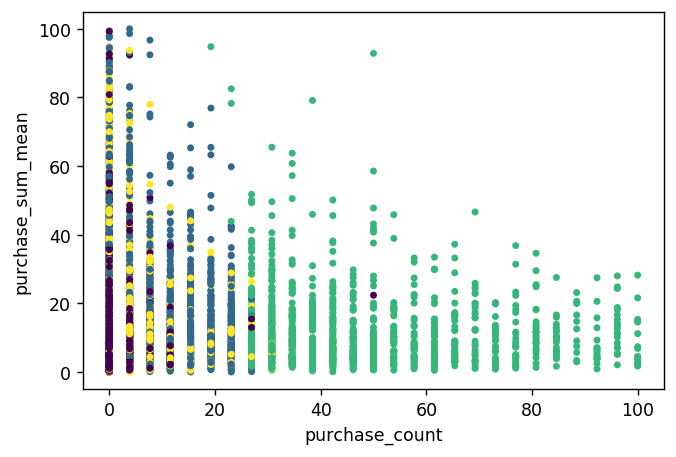

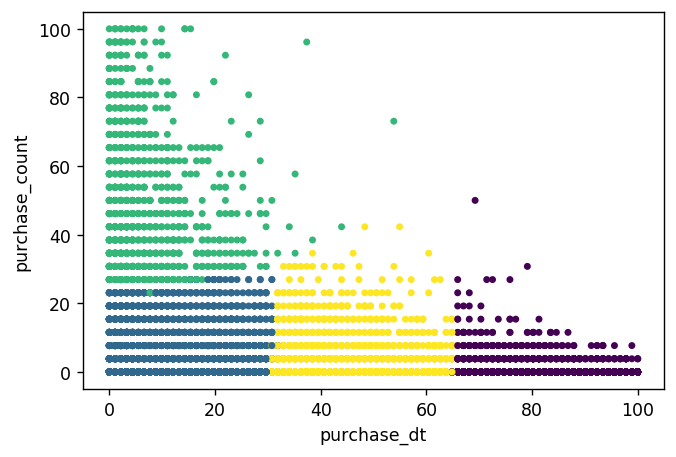

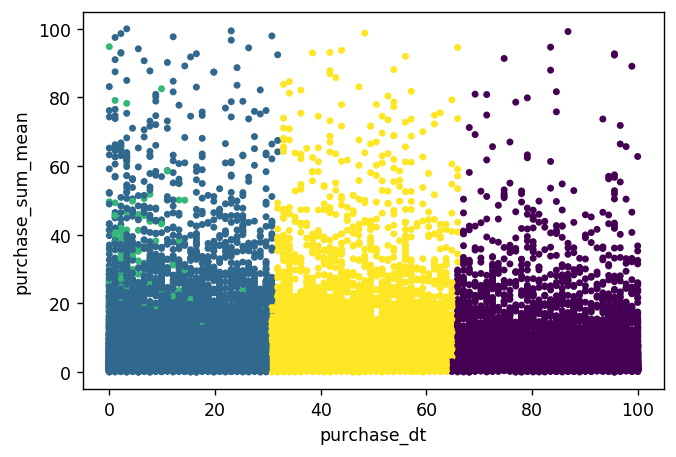

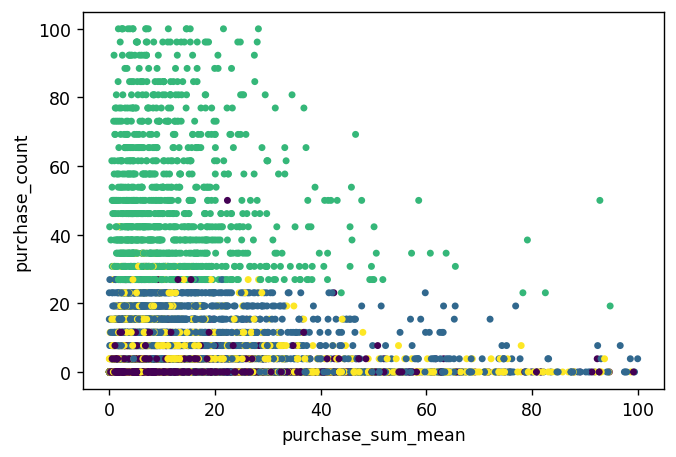

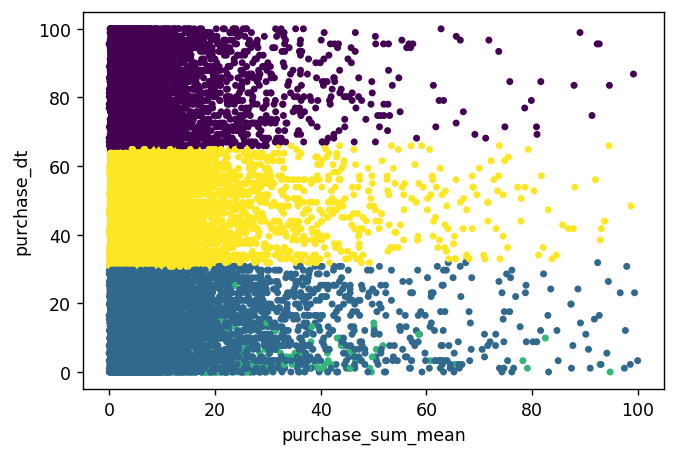

In [64]:
import matplotlib.pyplot as plt

cols = X.columns[:3]
c = X['cluster']

for i in range(3):
  for j in range(3):
    if i!=j:
      a = X[cols[i]]
      b = X[cols[j]]
      plt.figure(dpi=125)
      plt.scatter(a, b, c=c, cmap='viridis',marker='.')
      plt.xlabel(cols[i])
      plt.ylabel(cols[j])
      plt.show()

In [0]:
data.groupby(['Магазин']).sum().sort_values('Сумма Итоговая', ascending=False)

,Цена,Сумма Итоговая,Сумма скидки,Количество,Сумма скидки без округления,Сумма округления,shop_id,payment_method,purchase,td,cltv
Магазин,,,,,,,,,,,
Магазин 3,2.334865e+07,19219267.00,2113564.49,79415.191,2106062.34,7502.15,364386,220435,2684926374,3398768,6.382148e+09
Магазин 12,1.841999e+07,11804640.00,671722.12,48348.441,664107.70,7614.42,125298,161260,888790892,971957,2.427689e+09
Магазин 8,1.399853e+07,10678831.00,846745.62,46030.838,843060.30,3685.32,399443,130834,1466630201,1692919,2.445191e+09
Магазин 1,9.486454e+06,7023686.00,701324.99,34555.323,698527.25,2797.74,0,90586,1061383705,1681088,2.237914e+09
Магазин 4,7.553860e+06,6764715.00,635448.47,25332.160,633494.98,1953.49,125069,59515,396506650,807190,2.712694e+09
Магазин 7,5.711035e+06,5219994.00,417470.15,21101.892,415944.38,1525.77,168570,60375,270545350,627317,6.589277e+08
Магазин 5,6.457930e+06,5000360.00,451078.35,21177.629,449505.34,1573.01,151960,68063,155396348,809941,1.104558e+09
Магазин 6,5.789044e+06,4743907.00,293209.70,19161.126,291545.99,1663.71,154548,60982,250787425,561740,9.447459e+08
Магазин 2,3.091732e+06,2567911.00,203781.31,14388.864,202864.36,916.95,63545,49509,188244567,564729,5.297587e+08


In [0]:
data['Магазин'].unique()

array(['Магазин 1', 'Магазин 2', 'Магазин 3', 'Магазин 4', 'Магазин 5',
       'Магазин 6', 'Магазин 7', 'Магазин 8', 'Магазин 9', 'Магазин 10',
       'Магазин 11', 'Онлайн', 'Магазин 12', 'Магазин 13'], dtype=object)

In [65]:
data.loc[X[X['cluster'] == 0].index].groupby(['Магазин']).sum().sort_values('Сумма скидки', ascending=False)#.sum()

,Цена,Сумма Итоговая,Сумма скидки,Количество,Сумма скидки без округления,Сумма округления,purchase,time_delta,cLTV
Магазин,,,,,,,,,
Магазин 3,1974206.36,1644278.0,103368.78,6747.553,102850.21,518.57,232495283,19244,4.626693e+07
Магазин 8,1659598.97,1266573.0,42354.31,6615.111,41979.01,375.30,160429713,5611,9.167986e+06
Магазин 1,616407.91,469235.0,36521.61,2202.787,36357.24,164.37,63511529,4993,7.162663e+06
Магазин 5,906201.26,671934.0,30634.64,2997.821,30464.86,169.78,25547550,7800,1.751020e+07
Магазин 4,678553.51,630121.0,25536.98,2217.364,25416.27,120.71,31673636,3211,7.383832e+06
Магазин 6,972746.00,832813.0,22012.55,3352.002,21774.26,238.29,90394274,6930,1.290746e+07
Магазин 7,754538.24,632236.0,19486.28,2717.617,19323.37,162.91,82997907,5475,8.326922e+06
Магазин 2,370193.14,308628.0,14749.37,1591.356,14666.12,83.25,19857060,2702,5.358665e+06
Магазин 9,436597.00,432939.0,8262.98,1602.330,8181.59,81.39,25315359,57,1.632379e+05
